## **1. Importación de librerias y datos**
En este caso usaremos los datos limpios del precio nacional de cacao como base.

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

In [22]:
df_unificado = pd.read_excel('DatosCacao_multivariado.xlsx')
df_total = df_unificado.copy()

df_unificado = df_unificado.fillna(method='bfill')
train_size = int(len(df_unificado) * 0.8)
test_size = len(df_unificado) - train_size
df_unificado = df_unificado.iloc[:-test_size]
print(df_unificado.tail())


# Serie objetivo
y = df_unificado['COP/kg']

# Variables exógenas
X = df_unificado[['TRM', 'COP/kg (internacional)', 'Inflacion', 'COP/kg (futuro)',"Produccion"]]

        Fecha   COP/kg      TRM  COP/kg (internacional)  Inflacion  \
59 2025-03-10  23462.8  4116.80                34433.20       5.09   
60 2025-03-17  22958.2  4102.67                32237.84       5.09   
61 2025-03-24  23730.8  4168.82                33537.57       5.09   
62 2025-03-31  23407.5  4192.57                33168.13       5.09   
63 2025-04-07  23842.2  4274.03                33146.43       5.16   

    COP/kg (futuro)   Produccion  
59         34334.11  4452.759427  
60         32132.11  4452.759427  
61         33443.65  4452.759427  
62         33199.58  4452.759427  
63         33932.93  5201.885281  


In [17]:
import warnings

warnings.filterwarnings("ignore")

mejor_mse = float("inf")
mejores_parametros = None
mejor_modelo = None

p = d = q = range(0, 3)  # prueba valores de 0 a 2
P = D = Q = range(0, 2)  # valores típicos más bajos para estacionalidad
#s = [4, 12, 26, 52]  # periodicidad estacional

for s in [4, 12, 26, 52]:
    for i in p:
        for j in d:
            for k in q:
                for I in P:
                    for J in D:
                        for K in Q:
                            try:
                                modelo = SARIMAX(y,
                                                exog=X,
                                                order=(i,j,k),
                                                seasonal_order=(I,J,K,s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                resultado = modelo.fit(disp=False)

                                # Pronóstico
                                forecast = resultado.get_forecast(steps=test_size, exog=X[-test_size:])
                                pred_mean = forecast.predicted_mean
                                mse = mean_squared_error(df_total['COP/kg'][-test_size:], pred_mean)

                                if mse < mejor_mse:
                                    mejor_mse = mse
                                    mejores_parametros = ((i,j,k), (I,J,K,s))
                                    mejor_modelo = resultado
                            except:
                                continue

if mejores_parametros is not None:
    print(f'Mejor modelo SARIMA: orden no estacional {mejores_parametros[0]}, orden estacional {mejores_parametros[1]}, MSE: {mejor_mse}')
else:
    print("No se encontró un modelo SARIMA válido.")   


Mejor modelo SARIMA: orden no estacional (1, 1, 2), orden estacional (0, 1, 1, 4), MSE: 2895108.7672237568


## **2. Aplicación del modelo a los datos**

In [23]:
model = SARIMAX(y,
                exog=X,
                order=mejores_parametros[0],
                seasonal_order=mejores_parametros[1],
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

# Pronóstico a 52 semanas
forecast = results.get_forecast(steps=test_size, exog=X[-test_size:])
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

                                      SARIMAX Results                                      
Dep. Variable:                              COP/kg   No. Observations:                   64
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 4)   Log Likelihood                -468.140
Date:                             Tue, 16 Sep 2025   AIC                            956.280
Time:                                     11:28:07   BIC                            975.793
Sample:                                          0   HQIC                           963.761
                                              - 64                                         
Covariance Type:                               opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
TRM                       -3.9920      5.530     -0.722      0.470     -14.830    

In [24]:
n_train = len(y)
steps = len(pred_mean)

# Index de las fechas donde cae el forecast (las siguientes fechas en df_total después del train)
pred_index = df_total['Fecha'].iloc[n_train:n_train+steps].reset_index(drop=True)

# Asignar ese índice al forecast
pred_mean.index = pred_index
pred_ci.index = pred_index

In [25]:
# Calcular métricas de error
mae = mean_absolute_error(df_total['COP/kg'].iloc[-test_size:], pred_mean)
rmse = np.sqrt(mean_squared_error(df_total['COP/kg'].iloc[-test_size:], pred_mean))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 1268.9786
RMSE: 1564.1699


## **3. Visualización de los resultados del forecast**

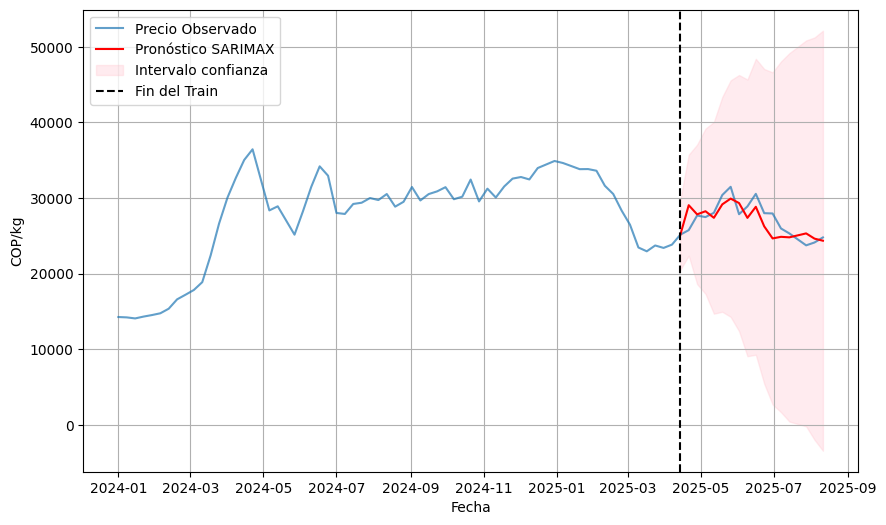

In [26]:
# Gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(df_total['Fecha'], df_total['COP/kg'], label='Precio Observado', color='C0', alpha=0.7)
plt.plot(pred_mean.index, pred_mean, label='Pronóstico SARIMAX', color='red')

plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='pink', alpha=0.3, label="Intervalo confianza")
plt.axvline(df_total['Fecha'].iloc[-test_size], color='k', linestyle='--', label='Fin del Train')

plt.xlabel('Fecha')
plt.ylabel('COP/kg')
plt.legend()
plt.grid(True)
plt.show()